# Practical Intro to AI Music

Before starting I highly recommend to listen to the samples located at the [`docs/intro-to-AI-music/examples`](./examples/) folder of this repository. 
All the MIDI samples there were generated with AI. It will give you a better idea of the results that you can achieve with AI music generation models.

### Imports and functions definition

In [1]:
import sys

sys.path.append('../../src/custom-gpt2/')

from make_token_sequence_dataset import process_midi_file

import librosa #0.9.2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa.display
import note_seq
import copy
import os
import math
from IPython.display import Audio
from note_seq import sequences_lib
from note_seq import constants
from transformers import PreTrainedTokenizerFast
from bertviz import head_view
from transformers import BertTokenizer, BertModel

# NOTE: Only works on windows. This dependency is used to start the .mp4 video at the root folder of this directory
from os import startfile


tokenizer = PreTrainedTokenizerFast(tokenizer_file='resources/example-tokenizer.json')

C:\Users\PedroFerreira\anaconda3\envs\intro-to-ai-music-env\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def plot_audio(audio_path):
    y, sr = librosa.load(audio_path)

    plt.plot(y)
    plt.title('Signal')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')

    return y

def plot_spectrogram(audio_signal):
    sg = librosa.feature.melspectrogram(audio_signal, sr=22050)
    db_spec = librosa.power_to_db(sg, ref=np.max)
    librosa.display.specshow(db_spec, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')

def convert_notes_seq_to_df(notes_seq, include_quantization=False):
    columns=['start_time', 'end_time', 'pitch', 'velocity']

    if include_quantization:
        columns.extend(['quantized_start_step', 'quantized_end_step'])

    df = pd.DataFrame(columns=columns)

    for note in notes_seq.notes:
        new_row = [note.start_time, note.end_time, note.pitch, note.velocity]

        if include_quantization:
            new_row.extend([note.quantized_start_step, note.quantized_end_step])

        df.loc[len(df)] = new_row
    return df

def transpose(sequence, transposition):
    """Transposes a note sequence by the specified transposition."""
    transposed_sequence = copy.deepcopy(sequence)
    for note in transposed_sequence.notes:
        if not note.is_drum:
            note.pitch += transposition
            if note.pitch < constants.MIN_MIDI_PITCH or note.pitch > constants.MAX_MIDI_PITCH:
                print(f'Warning: note {note} out of range. Skipping sequence')
                return None
    return transposed_sequence

def print_bert_viz(sentence_a, sentence_b):
    # Load model and retrieve attention
    model_version = 'bert-base-uncased'
    do_lower_case = True
    model = BertModel.from_pretrained(model_version, output_attentions=True)
    tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
    inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']
    attention = model(input_ids, token_type_ids=token_type_ids)[-1]
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)

    head_view(attention, tokens)

## What is music?

> "The art of arranging sound to create some combination of form, harmony, melody, rhythm or otherwise expressive content." - Wikipedia


Music is one of the universal aspects of all human societies. From tribes in the Amazon to small villages in the Chinese countryside, from ancient Greek society to contemporary digital society, humans use music as a means of expression.

## How can we perceive music?

In terms of information, we could see music being derived from two main raw sources, being them:
- Audio
- Music Information


### Audio

What is sound?

> "Sound is a vibration that propagates as an acoustic wave, through a transmission medium such as a gas, liquid or solid. In human physiology and psychology, sound is the reception of such waves and their perception by the brain." - Wikipedia


_**Metaphysics question**: If a tree falls in a forest, and there’s no one around to hear it, does it make a sound?_

Let's hear a `.wav` audio file with the first seconds of _Fur elise_ by Beethoven

In [3]:
sample = 'resources/fur_elise.wav'
Audio(sample, rate=22050)

How can we see this audio information? Let's plot the amplitude of the wave through time

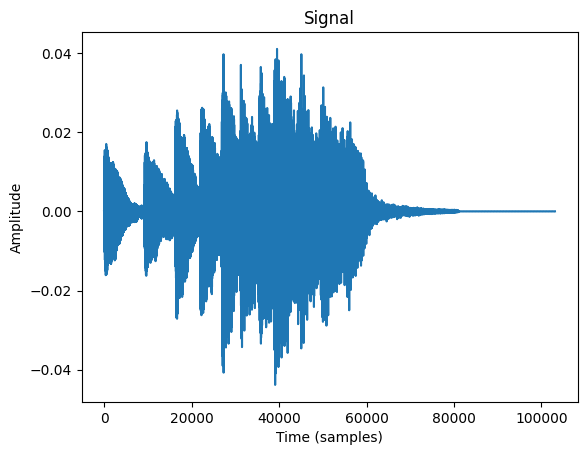

In [4]:
audio_signal = plot_audio(sample)

To exemplify in data terms, we can look to the structure of the signal

In [5]:
pd.DataFrame(audio_signal)

,0
0,-0.000004
1,-0.000001
2,-0.000016
3,-0.000021
4,-0.000019
...,...
103089,-0.000005
103090,-0.000002
103091,-0.000007
103092,-0.000002


So we have more than 100k of signal for the ~ 5 seconds of the audio (~ 5 * 22050 samples per second).
It's also interesting to see how the wave progress over time.
> Note: Try different numbers in the `sample` variable below to see how the wave changes over time

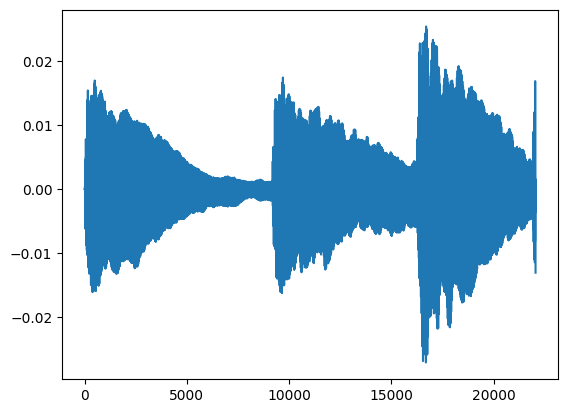

In [6]:
# sample = audio_signal[:10]
# sample = audio_signal[:1000]
# sample = audio_signal[:10000] # 0.5 second
# sample = audio_signal[:20000]
sample = audio_signal[:22050] # 1 second
# sample = audio_signal[:44100] # 2 seconds
# sample = audio_signal # full sample

plt.plot(sample)

But we want to identify something in the wave, right? Something like a note or an instrument. So first we need to extract some information out of these waves, such as frequency and intensity.

One way to achieve this is to use Short Time Fast Fourier Transform in order to extract the spectrogram of the wave. Let's see how a Fourier Transformation decomposes complex signals

In [7]:
# NOTE: ONLY WORKS ON WINDOWS
# librosa plot spectrogram
startfile("fourier_transform.mp4")

With the decomposition of the waves, we can move the sound to the frequency domain, where we are able to extract relevant musical information such as note pitch (from the frequency of the wave) and its intensity (in decibels)

Let's plot the result of the wave transformation

C:\Users\PedroFerreira\AppData\Local\Temp\ipykernel_23392\1782231548.py:12: FutureWarning: Pass y=[-4.0167492e-06 -1.4888453e-06 -1.5818538e-05 ... -7.2201651e-06
 -2.4809844e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  sg = librosa.feature.melspectrogram(audio_signal, sr=22050)


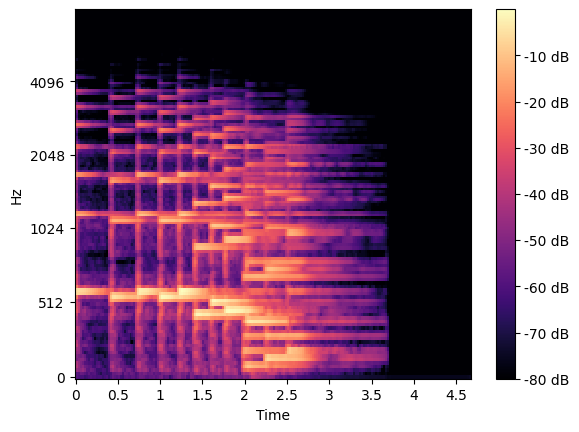

In [8]:
plot_spectrogram(audio_signal)

Now we are already able to see the "musical movement" of the audio, but that was a lot of work already.
For 5 seconds of music we processed 100k data points, and we don't even have a way to really extract notes.

It's also important to remember that when we talk about deep learning, we are talking about considerable amounts of data.

Is there an efficient way to extract music information? 



### Music Information

Music Information is a way to represent music in a more abstract fashion, where we can extract musical information such as notes, chords, instruments, etc.
There are many of these representations, including tabs, sheet music, MIDI, etc. Here we enter the domain of symbolic music, where we can represent music through symbols.

MIDI is a digital way to represent music information, where we can interact with musical events such as **note on**, **note off**, **instrument**, **intensity**, etc.

# Feature engineering of MIDI

## Augmentation

more data == more examples to learn.

On the [maestro dataset](https://magenta.tensorflow.org/datasets/maestro) we have 1276 different examples from the piano competition.

What if we generate some synthetic data on top of that? First, let's see the plot of the notes of the first three seconds of Fur Elise (Beethoven)

In [9]:
midi_file = 'resources/fur_elise.mid'

fur_elise_notes_sequence = note_seq.midi_file_to_note_sequence(midi_file)

note_seq.plot_sequence(fur_elise_notes_sequence)

Loading BokehJS ...

From the graph above we can see the distribution of notes (pitch) through time. Now let's see the same musical events within this MIDI file:

In [10]:
print(fur_elise_notes_sequence)

ticks_per_quarter: 220
time_signatures {
  numerator: 4
  denominator: 4
}
tempos {
  qpm: 120
}
notes {
  pitch: 76
  velocity: 48
  start_time: 0.27499999999999997
  end_time: 1.0113636363636362
}
notes {
  pitch: 75
  velocity: 47
  start_time: 0.69090909090909092
  end_time: 1.075
}
notes {
  pitch: 76
  velocity: 59
  start_time: 1.0113636363636362
  end_time: 1.4909090909090907
}
notes {
  pitch: 71
  velocity: 60
  start_time: 1.6840909090909091
  end_time: 2.3249999999999997
}
notes {
  pitch: 72
  velocity: 66
  start_time: 2.0363636363636362
  end_time: 2.3249999999999997
}
notes {
  pitch: 74
  velocity: 62
  start_time: 1.875
  end_time: 2.3249999999999997
}
notes {
  pitch: 75
  velocity: 63
  start_time: 1.2681818181818181
  end_time: 2.3249999999999997
}
notes {
  pitch: 76
  velocity: 69
  start_time: 1.4909090909090907
  end_time: 2.3249999999999997
}
notes {
  pitch: 45
  velocity: 55
  start_time: 2.2590909090909088
  end_time: 2.9499999999999997
}
notes {
  pitch: 5

Now talking about data augmentation, what if we stretch the time to increase the signal of the same pattern but in a different time distribution?

In [11]:
# Time stretch range
STRETCH_RANGE = [0.5, 0.75, 1.0, 1.25, 1.5]
# Output files directory
TIME_AUGMENTATION_OUTPUT_PATH = 'data/time_augmentation/'

# Creates directory if not exists
if not os.path.exists(TIME_AUGMENTATION_OUTPUT_PATH):
    os.makedirs(TIME_AUGMENTATION_OUTPUT_PATH)

stretched_sequences = [
    sequences_lib.stretch_note_sequence(fur_elise_notes_sequence, stretch_factor)
    for stretch_factor in STRETCH_RANGE
]

for sequence, stretch in zip(stretched_sequences, STRETCH_RANGE):
    filename = f'{TIME_AUGMENTATION_OUTPUT_PATH}/fur_elise_{stretch}.midi'
    note_seq.sequence_proto_to_midi_file(sequence, filename)

With the time transformation, we can get 4 extra files for each MIDI file.
> Check the `data/time_augmentation` directory to see the results of data augmentation through time


And what if we transpose the tonality of the sequence? We can get a whole octave of transpositions (12 notes) to represent all the tonalities.

Taking into consideration that we are talking about adding, on the pitch value, we can leverage mathematically the computation by setting the center of the 12 transpositions to 0.

This trick also prevent us from "running out of keys" for higher octaves

In [12]:
DEFAULT_RANGE = (list(range(1, 13)))
TRANSPOSITION_RANGE = (list(range(-6, 6)))

print(DEFAULT_RANGE)
print(TRANSPOSITION_RANGE)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]


Now let's transpose fur elise and see the results

In [13]:
TRANSPOSITION_AUGMENTATION_OUTPUT_PATH = 'data/transposition_augmentation/'

# Creates directory if not exists
if not os.path.exists(TRANSPOSITION_AUGMENTATION_OUTPUT_PATH):
    os.makedirs(TRANSPOSITION_AUGMENTATION_OUTPUT_PATH)

transposed_sequences = [
    transpose(fur_elise_notes_sequence, transposition)
    for transposition in TRANSPOSITION_RANGE
]

for sequence, transposition in zip(transposed_sequences, TRANSPOSITION_RANGE):
    filename = f'{TRANSPOSITION_AUGMENTATION_OUTPUT_PATH}/fur_elise_{transposition}.midi'
    note_seq.sequence_proto_to_midi_file(sequence, filename)

Now we have 4 extra files derived from time augmentation and 11 extra files derived from transposition augmentation.

Considering the data split used in the paper, we have a training dataset of 1099 files (does not include validation). After the combination of transformations, we will have 66,117 performances (1099 * 5 * 12)

Nice! We considerably augmented the dataset, meaning that the AI will have a lot more examples to learn from.

Now, let's start transforming this data to something more concrete

## Cleaning

### Pedal Control

Although we have most of the musical information in place, we are still missing the piano pedal. Let's see the difference.

Bellow we can see the same information shown as a dictionary before in a table format

In [14]:
fur_elise_notes_sequence_df = convert_notes_seq_to_df(fur_elise_notes_sequence)
fur_elise_notes_sequence_df

,start_time,end_time,pitch,velocity
0,0.275000,1.011364,76.0,48.0
1,0.690909,1.075000,75.0,47.0
2,1.011364,1.490909,76.0,59.0
3,1.684091,2.325000,71.0,60.0
4,2.036364,2.325000,72.0,66.0
5,1.875000,2.325000,74.0,62.0
6,1.268182,2.325000,75.0,63.0
7,1.490909,2.325000,76.0,69.0
8,2.259091,2.950000,45.0,55.0
9,2.515909,2.950000,52.0,55.0


The fur elise sample does not use pedal. Let's use a random sample from MAESTRO dataset and apply the pedal to the note duration and see how it compares

In [15]:
## Creates new sequence with piano pedal applied
sample_pedal_midi_note_sequence = note_seq.midi_file_to_note_sequence('resources/sample_pedal.midi')
sample_extended_notes = note_seq.apply_sustain_control_changes(sample_pedal_midi_note_sequence)

# Convert old sequence and new sequence into a tabular format
without_pedal_notes_seq_df = convert_notes_seq_to_df(sample_pedal_midi_note_sequence)
sample_with_pedal_notes_seq_df = convert_notes_seq_to_df(sample_extended_notes)

# Append new column of extended notes
comparison_df = pd.DataFrame(
    {
        'without_pedal_end_time': without_pedal_notes_seq_df['end_time'],
        'with_pedal_end_time': sample_with_pedal_notes_seq_df['end_time']
    }
)

comparison_df.head(50)

,without_pedal_end_time,with_pedal_end_time
0,2.255208,4.027083
1,2.775000,4.027083
2,2.780208,2.935417
3,2.923958,4.027083
4,3.017708,4.027083
5,3.075000,3.970833
6,3.455208,4.027083
7,4.079167,4.079167
8,4.105208,4.105208
9,4.532292,7.540625


We need to think about how are we modeling music now in a more concrete way.

So we already know that we have 4 elements from MIDI events to be mapped, being **pitch**, **velocity**, **start_time** and **end_time**.

We need to discretize all the possibilities of those 4 dimensions into tokens, so the model can process. The amount of tokens grows linearly with the complexity of the model.

The **start_time** and **end_time** have infinite possibilities since time is continuous.

First, let's map the possibilities of "starts" and "ends" inside the sample time space


In [16]:
sample_with_pedal_start_time_possibilities = \
    len(set(sample_with_pedal_notes_seq_df['start_time']))


sample_with_pedal_end_time_possibilities = \
    len(set(sample_with_pedal_notes_seq_df['end_time']))

print('Note start time possibilities:', sample_with_pedal_start_time_possibilities)
print('Note end time possibilities', sample_with_pedal_end_time_possibilities)

Note start time possibilities: 6160
Note end time possibilities 3397


9.5k of tokens just for the start_time and end_time of one single musical excerpt, that's huge! I'm sure we can simplify that.

Before going to that direction, let's have a look to the other features that we have:

In [17]:
sample_with_pedal_notes_seq_df.head(50)

,start_time,end_time,pitch,velocity
0,1.718750,4.027083,48.0,28.0
1,1.104167,4.027083,58.0,20.0
2,1.037500,2.935417,70.0,55.0
3,2.192708,4.027083,49.0,36.0
4,2.558333,4.027083,53.0,36.0
5,1.080208,3.970833,66.0,39.0
6,2.869792,4.027083,54.0,39.0
7,2.935417,4.079167,70.0,59.0
8,3.335417,4.105208,51.0,36.0
9,3.976042,7.540625,44.0,39.0


Let's talk about pitch and velocity.

- **pitch** is the number of the note itself, so here we are relying on the MIDI specification, which maps 128 types of different notes (a regular piano has 88 notes)
- **velocity** can be seen as the note intensity. In MIDI we have 128 velocities

We cannot reduce the numerical scope of the pitch, otherwise we would lose valuable signal.
On the other hand, 128 types of velocities can be seemed as "too much" for our representation purposes, considering that music notation include 8 levels (from **___ppp___** to **___fff___**)

So with that in mind, we might reduce the scope of our velocity by quantizing it into smaller buckets.

Let's see an easy example on how can we do that. Let's take a vector of 128 possibilities


In [18]:
elements = list(range(1, 129))
print(elements)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128]


Let's manually quantize this in 4 buckets that would result in:
- 1 : 30 = bucket 1
- 30 : 60 = bucket 2
- 60 : 90 = bucket 3
- 90 : 120 = bucket 4

In [19]:
bucketized_elements = []

for element in elements:
    if element <= 30:
        bucketized_elements.append(1)

    elif 30 < element <= 60:
        bucketized_elements.append(2)

    elif 60 < element <= 90:
        bucketized_elements.append(3)

    else:
        bucketized_elements.append(4)

print(bucketized_elements)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Great! But 4 buckets might not represent very well the velocities possibilities since we have the double of this in music notation.

So we might be in a good spot between > 8 and < 128.

If we go 4 times the number of intensities that we have in music notation, we end with 32 buckets (8*4).

We can simplify the bucketizing process with a simple mathematical formula:


In [20]:
bin_size = 128 / 32

quantized_velocities = [(((element - 1) // bin_size) + 1) for element in elements]
print(quantized_velocities)

[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 18.0, 18.0, 19.0, 19.0, 19.0, 19.0, 20.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 22.0, 22.0, 22.0, 22.0, 23.0, 23.0, 23.0, 23.0, 24.0, 24.0, 24.0, 24.0, 25.0, 25.0, 25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 28.0, 28.0, 28.0, 28.0, 29.0, 29.0, 29.0, 29.0, 30.0, 30.0, 30.0, 30.0, 31.0, 31.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0]


Now we are able to represent the velocity information in a lower set of possibilities.

In [21]:
sample_with_pedal_notes_seq_df

,start_time,end_time,pitch,velocity
0,1.718750,4.027083,48.0,28.0
1,1.104167,4.027083,58.0,20.0
2,1.037500,2.935417,70.0,55.0
3,2.192708,4.027083,49.0,36.0
4,2.558333,4.027083,53.0,36.0
...,...,...,...,...
6311,870.151042,872.763542,62.0,99.0
6312,870.145833,872.763542,69.0,100.0
6313,870.143750,872.763542,74.0,105.0
6314,870.156250,872.763542,50.0,89.0


Now, what if instead of calculating the **pitch** (note) in function of **start_time** and **end_time**, we calculate the time difference in function of a note_start and a note_end?

In [22]:
time_difference_possibilities = \
    sample_with_pedal_notes_seq_df['start_time'] - sample_with_pedal_notes_seq_df['end_time']

total_sample_time_difference_possibilities = len(set(time_difference_possibilities))
print(total_sample_time_difference_possibilities)

3775


In [23]:
total_tokens_with_start_and_end = \
    sample_with_pedal_start_time_possibilities + \
    sample_with_pedal_end_time_possibilities + \
    128 + \
    32

total_tokens_with_time_difference = \
    total_sample_time_difference_possibilities + \
    128 + \
    128 + \
    32

print(f'Total tokens possibilities with start_time and end_time: {total_tokens_with_start_and_end}')
print(f'Total tokens possibilities with time difference: {total_tokens_with_time_difference}')

Total tokens possibilities with start_time and end_time: 9717
Total tokens possibilities with time difference: 4063


So we reduced the token possibilities considerably! But 4063 is still a lot of tokens. Can we optimize that? Let's have a look in the time difference possibilities of the sample performance:

In [24]:
ordered_time_difference = pd.Series(time_difference_possibilities).sort_values()
ordered_time_difference

4619   -18.746875
4618   -17.900000
4880   -16.503125
4881   -16.008333
4620   -15.930208
          ...    
3415    -0.011458
6012    -0.001042
3425    -0.001042
6153    -0.001042
4381    -0.001042
Length: 6316, dtype: float64

We can see that the time difference is in its majority at the milliseconds level!

In this case, we could also apply the dimensionality reduction to the time domain, by quantizing it, meaning "chopping the decimals"

Here we will move the time difference from the seconds domain to the milliseconds domain by cutting 1 second in intervals of 100 steps, resulting in 10 milliseconds rounding

In [25]:
quantized_sequence = sequences_lib.quantize_note_sequence_absolute(sample_extended_notes, 100)
sample_with_pedal_quantized_df = convert_notes_seq_to_df(quantized_sequence, include_quantization=True)

quantized_time_difference = sample_with_pedal_quantized_df['quantized_start_step'] - sample_with_pedal_quantized_df['quantized_end_step']

ordered_quantized_time_difference = pd.Series(quantized_time_difference).sort_values()


pd.DataFrame({
    'non_quantized_time_difference': ordered_time_difference[:100],
    'quantized_time_difference': ordered_quantized_time_difference[:100],
})

C:\Users\PedroFerreira\AppData\Local\Temp\ipykernel_23392\2889171081.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  'non_quantized_time_difference': ordered_time_difference[:100],
C:\Users\PedroFerreira\AppData\Local\Temp\ipykernel_23392\2889171081.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  'quantized_time_difference': ordered_quantized_time_difference[:100],


,non_quantized_time_difference,quantized_time_difference
92,-5.929167,-592.0
93,-6.811458,-681.0
146,-6.207292,-620.0
209,-6.745833,-674.0
212,-5.879167,-588.0
...,...,...
4898,-5.481250,-548.0
4899,-5.491667,-549.0
5133,-8.685417,-869.0
5134,-8.705208,-871.0


Now, if we map the possibilities inside the quantized time space, we will be able to see how the same information can be represented in smaller tokens

In [26]:
print(len(set(ordered_time_difference)))
print(len(set(ordered_quantized_time_difference)))

3775
526


Big difference! But is there a way to make this vocabulary even smaller? 526 is the possibilities within this music only! We are still in a considerable continuous space.

We could break intervals bigger than one second into two intervals, e.g. 1200 in (1000 + 200). That would put us in a position where we can have 1000 time possibilities!

But are we that sensible to time change? Can we perceive all the 1000ms within a second?

According to science, no! Researchers show that the perceptible difference in temporal displacement of a single tone in a sequence was not less than approximately 10ms for the most part.


So in majority, we cannot perceive less than 10ms. With that in mind, we can take that in consideration and bucketize our quantized time in 10ms steps.

Since we are taking as long as one second (1000ms), with 10ms steps we will have a total scope of 100 (1000 / 10) possibilities!

With all that sets of transformation, we reduce the possibilities of time difference from infinity to 100.

Let's get the fur elise example again and see how the end result of this would look like:


In [27]:
# Get original time difference
fur_elise_original_time_difference = fur_elise_notes_sequence_df['end_time'] - fur_elise_notes_sequence_df['start_time']

# Get quantized time difference
fur_elise_quantized_sequence = sequences_lib.quantize_note_sequence_absolute(fur_elise_notes_sequence, 100)
fur_elise_quantized_sequence_df = convert_notes_seq_to_df(quantized_sequence, True)

fur_elise_q_time_difference = fur_elise_quantized_sequence_df['quantized_end_step'] - fur_elise_quantized_sequence_df['quantized_start_step']

pd.DataFrame({
    'Original time difference' : fur_elise_original_time_difference,
    'Quantized time difference' : fur_elise_q_time_difference,
})

,Original time difference,Quantized time difference
0,0.736364,231.0
1,0.384091,293.0
2,0.479545,190.0
3,0.640909,184.0
4,0.288636,147.0
...,...,...
6311,NaN,261.0
6312,NaN,261.0
6313,NaN,262.0
6314,NaN,260.0


In [28]:
new_sequence = []

for index, time in enumerate(fur_elise_q_time_difference):
    if time > 100:
        new_sequence.append(100)
        new_sequence.append(time - 100)
    else:
        new_sequence.append(time)

print(new_sequence[:50])

[100, 131.0, 100, 193.0, 100, 90.0, 100, 84.0, 100, 47.0, 100, 189.0, 100, 16.0, 100, 14.0, 77.0, 100, 256.0, 100, 13.0, 100, 257.0, 100, 134.0, 100, 82.0, 100, 257.0, 100, 262.0, 100, 72.0, 100, 29.0, 100, 23.0, 49.0, 51.0, 52.0, 100, 109.0, 100, 50.0, 100, 49.0, 100, 37.0, 100, 14.0]


With that we have everything to clean and optimize musical features from a MIDI dataset, creating a very simple language model.
Let's see the vocabulary of this language:
- 128 possible **note_on** events
- 128 possible **note_off** events
- 32 possible types of **velocities** (intensity)
- 100 possible types of **time shift** events

So far, we are able to map this music language in 388 different tokens

We can also add **piece_start** and **piece_end** to indicate signals of when the music starts and finishes

This sums up to 390 tokens! That is the vocabulary of this music language!

Now let's see how that looks like by processing the fur elise midi file into events!

In [29]:
token_sequences = process_midi_file(midi_file)
print(f'Total of returned sequences: {len(token_sequences)}')
print(token_sequences[30])
note_seq.plot_sequence(fur_elise_notes_sequence)

Total of returned sequences: 60
piece_start time_shift=14 velocity=12 note_on=76 time_shift=21 note_on=75 time_shift=16 note_off=76 velocity=15 note_on=76 time_shift=3 note_off=75 time_shift=9 velocity=16 note_on=75 time_shift=12 note_off=76 velocity=18 note_on=76 time_shift=9 velocity=15 note_on=71 time_shift=10 velocity=16 note_on=74 time_shift=8 velocity=17 note_on=72 time_shift=11 velocity=14 note_on=45 time_shift=2 velocity=15 note_on=69 time_shift=1 note_off=75 note_off=76 note_off=71 note_off=74 note_off=72 time_shift=10 velocity=14 note_on=52 time_shift=13 velocity=13 note_on=57 time_shift=9 note_off=45 note_off=69 note_off=52 note_off=57 piece_end


Loading BokehJS ...

The tokens shown above are derived from the preprocessing of the MIDI events to the music language. But we still need to map this language into a numerical representation. 
That's where the tokenizer comes in to assign a numerical value to each token of the music language.

In [30]:
tokenized_input = tokenizer.encode(token_sequences[0])
print(tokenized_input)

[284, 85, 20, 58, 137, 40, 105, 57, 13, 58, 6, 39, 23, 11, 40, 47, 57, 8, 58, 23, 13, 34, 25, 11, 56, 22, 9, 65, 30, 15, 150, 5, 13, 46, 4, 39, 57, 33, 55, 64, 25, 15, 113, 70, 17, 91, 23, 149, 45, 112, 90, 283]


## Model Training

One interactive way to understand how neural architectures learn is by provided by google in this [Neural Network Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.70302&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

---

It's also worth highlighthing the differences between AI, Machine Learning and Deep Learning with the following image:

<img src="resources/ai-ml-dl.jpg" height="800">

# Multi-head attention

The attention mechanism is a powerful tool that allows the model to focus on the most relevant parts of the input sequence. It is used in many NLP tasks, such as machine translation, text summarization, and question answering. The attention mechanism is also used in the Transformer architecture, which is the core of the Transformers models used in this work (**Music Transformer, MuseNet, Custom-GPT2**).

This is a deep subject that I will not cover in this notebook, but I think it's intersting to end this notebook by seeing how those attention connections work with the following visualization:


In [31]:
sentence_a = "The cat sat on the mat"
sentence_b = "The cat lay on the rug"
print_bert_viz(sentence_a, sentence_b)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>